Let's now take a look at some of our data, starting with the base, non-aggregated data tables:

In [2]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.types import StringType
from delta.tables import DeltaTable
import matplotlib.pyplot as plt


spark_conf = (
        SparkConf()
        .set("spark.jars.packages", 'org.apache.hadoop:hadoop-client:3.3.4,org.apache.hadoop:hadoop-aws:3.3.4,io.delta:delta-spark_2.12:3.0.0')
    
        .set("spark.driver.memory", "6g")
    
        .set("spark.hadoop.fs.s3a.endpoint", "localhost:9000")
        .set("spark.hadoop.fs.s3a.access.key", "accesskey")
        .set("spark.hadoop.fs.s3a.secret.key", "secretkey" )
        .set("spark.hadoop.fs.s3a.path.style.access", "true") 
        .set("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        .set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')
        .set("spark.hadoop.fs.s3a.connection.ssl.enabled", "false")

        .set("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") 
        .set("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    )


sc = SparkContext.getOrCreate(spark_conf)
spark = SparkSession(sc)

In [3]:
exchange_rates = spark.read.format("delta").load('s3a://project/exchange_rates')
gdp = spark.read.format("delta").load('s3a://project/gdp')
pop = spark.read.format("delta").load('s3a://project/population')
country_codes = spark.read.format("delta").load('s3a://project/country_codes')

exchange_rates.sort("effective_date").show(5)
country_codes.show(5)
gdp.show(5)
pop.show(5)

24/01/16 17:24:34 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
24/01/16 17:24:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------------+-------------------+
|currency|exchange_rate|     effective_date|
+--------+-------------+-------------------+
|     AUD|       2.0227|2002-01-02 00:00:00|
|     ATS|        0.258|2002-01-02 00:00:00|
|     BEF|     0.087992|2002-01-02 00:00:00|
|     CZK|       0.1125|2002-01-02 00:00:00|
|     DKK|       0.4772|2002-01-02 00:00:00|
+--------+-------------+-------------------+
only showing top 5 rows

+-------------+--------------------+------------------+------+
|currency_code|       currency_name|           country|alpha3|
+-------------+--------------------+------------------+------+
|          SEK|       Swedish krona|            Sweden|   SWE|
|          HUF|    Hungarian forint|           Hungary|   HUN|
|          GBP|       British pound|    United Kingdom|   GBR|
|          ITL|        Italian lira|             Italy|   ITA|
|          XDR|Special drawing r...|IMF (for deletion)|   IMF|
+-------------+--------------------+------------------+------+
onl

Now let's move on to the aggregated tables:

In [13]:
highest_rate_30d = spark.read.format("delta").load('s3a://project/highest_rates_30_days')
highest_rate_30d.show()

+------------------+-------------+--------------------+--------------+------+
|mean_exchange_rate|currency_code|       currency_name|       country|alpha3|
+------------------+-------------+--------------------+--------------+------+
|            5.0334|          GBP|       British pound|United Kingdom|   GBR|
|            4.6442|          CHF|         Swiss franc|   Switzerland|   CHE|
|            4.3471|          EUR|                Euro|European Union|   EUE|
|            3.9629|          USD|United States dollar| United States|   USA|
|            2.9829|          SGD|    Singapore dollar|     Singapore|   SGP|
|            2.9714|          CAD|     Canadian dollar|        Canada|   CAN|
|            2.6699|          AUD|   Australian dollar|     Australia|   AUS|
|            2.4796|          NZD|  New Zealand dollar|   New Zealand|   NZL|
|            2.2226|          BGN|       Bulgarian lev|      Bulgaria|   BGR|
|            1.0795|          ILS|  Israeli new shekel|        I

Here we have table of currencies with highest mean exchange rates in the last 30 days. We can use our population and gdp tables to show some basic information about the country with most expensive currency:

In [5]:
def plot_country(country):
    pop = spark.read.format("delta").load('s3a://project/population')
    gdp = spark.read.format("delta").load('s3a://project/gdp')

    gdp = gdp.filter(f.col("country") == country)
    pop = pop.filter(f.col("country") == country)
    
    gdp_values = list(gdp.collect()[0])[1:]
    pop_values = list(pop.collect()[0])[1:]
    years = gdp.schema.names[1:]

    
    fig, ax = plt.subplots(2,1, figsize = (8,8))
    fig.tight_layout(pad = 5)
    ax1 = ax[0]
    ax2 = ax[1]

    ax1.plot(years[:24], gdp_values[:24], label = "measured")
    ax1.plot(years[23:], gdp_values[23:], ls = "--",  label = "predicted")
    ax1.set_title(f"GDP of {country}",  fontsize = 15, pad = 10)
    ax1.set_xticks(['2000', '2005', '2010', '2015', '2020', '2025'])
    ax1.set_xlabel("Year", fontsize = 13, labelpad =  10)
    ax1.set_ylabel("GDP  [billions USD]", fontsize = 13, labelpad = 10)

    ax1.set_facecolor("#EFEFEF")
    ax1.grid(color = 'white', linewidth = 1)
    ax1.legend()


    ax2.plot(years[:24], pop_values[:24], label = "measured")
    ax2.plot(years[23:], pop_values[23:], ls = "--",  label = "predicted")
    ax2.set_title(f"Population of {country}",  fontsize = 15, pad = 10)
    ax2.set_xticks(['2000', '2005', '2010', '2015', '2020', '2025'])
    ax2.set_xlabel("Year", fontsize = 13, labelpad =  10)
    ax2.set_ylabel("Population  [millions]", fontsize = 13, labelpad = 10)

    ax2.set_facecolor("#EFEFEF")
    ax2.grid(color = 'white', linewidth = 1)
    ax2.legend()

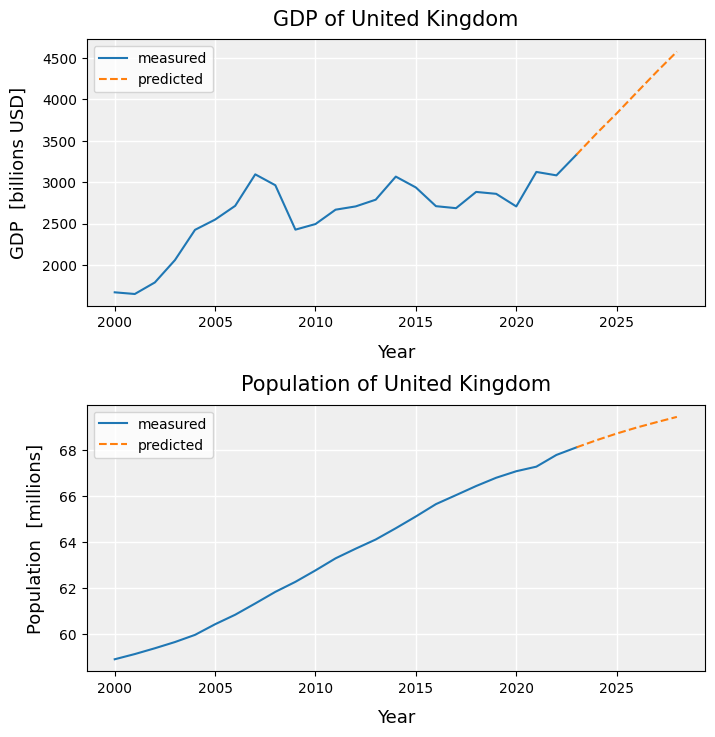

In [14]:
current_country = highest_rate_30d.collect()[0][3]
plot_country(current_country)

Now let's look at currencies with highest relative change of exchange rate:

In [15]:
highest_gain_30d = spark.read.format("delta").load('s3a://project/highest_gains_30_days')
highest_gain_30d.show()

+-----------------------+-------------+-----------------+--------------+------+
|exchange_change_percent|currency_code|    currency_name|       country|alpha3|
+-----------------------+-------------+-----------------+--------------+------+
|                  2.591|          CHF|      Swiss franc|   Switzerland|   CHE|
|                  2.389|          HUF| Hungarian forint|       Hungary|   HUN|
|                  1.739|          MXN|     Mexican peso|        Mexico|   MEX|
|                  1.459|          BRL|   Brazilian real|        Brazil|   BRA|
|                  1.421|          MYR|Malaysian ringgit|      Malaysia|   MYS|
|                  1.104|          NOK|  Norwegian krone|        Norway|   NOR|
|                  0.986|          PHP|  Philippine peso|   Philippines|   PHL|
|                  0.691|          GBP|    British pound|United Kingdom|   GBR|
|                  0.645|          EUR|             Euro|European Union|   EUE|
|                  0.586|          DKK| 

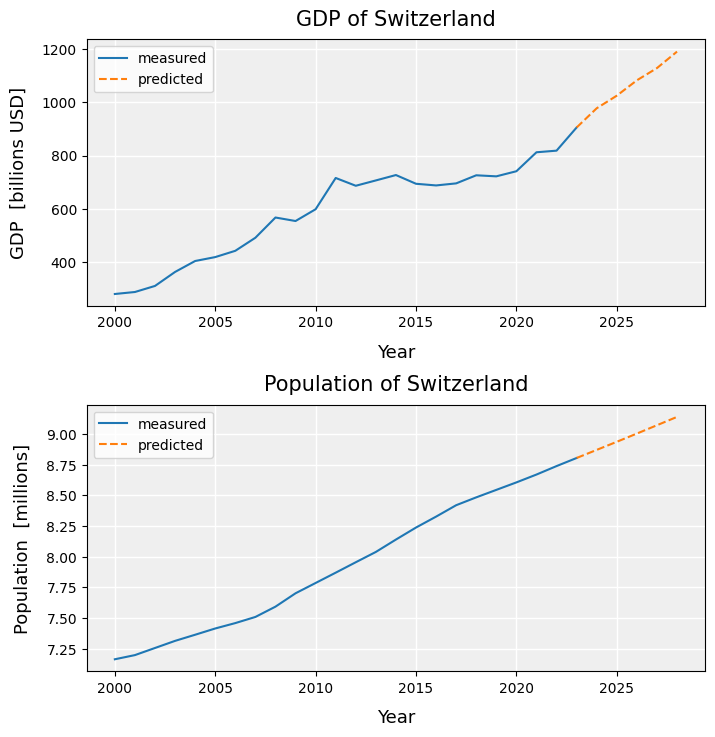

In [16]:
current_country = highest_gain_30d.collect()[0][3]
plot_country(current_country)

Last table that we already have stored is the table of most volatile currencies:

In [9]:
highest_volatility_30d = spark.read.format("delta").load('s3a://project/highest_volatility_30_days')
highest_volatility_30d.show()

+----------------+-------------+--------------------+--------------------+------+
|relative_rate_sd|currency_code|       currency_name|             country|alpha3|
+----------------+-------------+--------------------+--------------------+------+
|           2.126|          NOK|     Norwegian krone|              Norway|   NOR|
|           2.099|          UAH|   Ukrainian hryvnia|             Ukraine|   UKR|
|           1.572|          CLP|        Chilean peso|               Chile|   CHL|
|            1.56|          TRY|        Turkish lira|Türkiye, Republic of|   TUR|
|           1.189|          PHP|     Philippine peso|         Philippines|   PHL|
|            1.03|          USD|United States dollar|       United States|   USA|
|           1.027|          HKD|    Hong Kong dollar|       Hong Kong SAR|   HKG|
|           0.938|          INR|        Indian rupee|               India|   IND|
|           0.927|          ZAR|  South African rand|        South Africa|   ZAF|
|           0.91

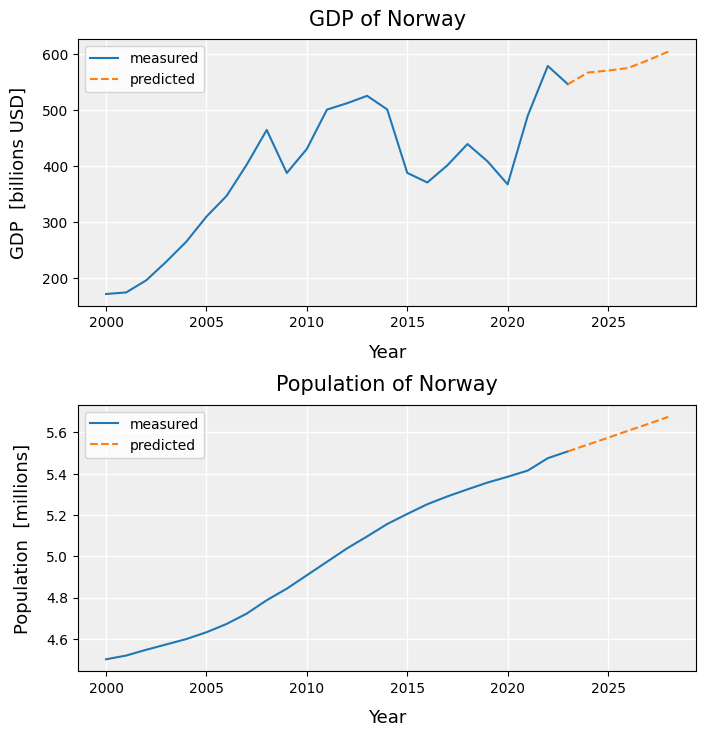

In [10]:
current_country = highest_volatility_30d.collect()[0][3]
plot_country(current_country)

We don't have to limit ourselves to only using the aggregated data tables, we can also perform operations on the main stream. For example, let's find the highest exchange rate for every currency in the available time period:

In [11]:
from pyspark.sql import Window

country_codes = spark.read.format("delta").load('s3a://project/country_codes')
exchange_rates_df = spark.read.format("delta").load('s3a://project/exchange_rates')

exchange_rates_partition = Window.partitionBy('currency')
exchange_rates_max = exchange_rates_df.withColumn('max_rate', f.max('exchange_rate').over(
    exchange_rates_partition)).where(
        f.col('exchange_rate') == f.col('max_rate')).sort(
            f.col("max_rate").desc()).drop("exchange_rate")

exchange_rates_max = exchange_rates_max.join(country_codes, on = exchange_rates_max.currency == country_codes.currency_code).sort(f.col("max_rate").desc()).drop("currency_code")


exchange_rates_max.show()

+--------+-------------------+--------+--------------------+--------------------+------+
|currency|     effective_date|max_rate|       currency_name|             country|alpha3|
+--------+-------------------+--------+--------------------+--------------------+------+
|     MTL|2004-03-01 00:00:00|  11.513|        Maltese lira|               Malta|   MLT|
|     CYP|2004-03-01 00:00:00|  8.3951|       Cypriot pound|              Cyprus|   CYP|
|     LVL|2004-04-15 00:00:00|   7.406|        Latvian lats|              Latvia|   LVA|
|     GBP|2004-03-01 00:00:00|  7.3516|       British pound|      United Kingdom|   GBR|
|     CHF|2022-09-29 00:00:00|    5.12|         Swiss franc|         Switzerland|   CHE|
|     USD|2022-09-28 00:00:00|  5.0381|United States dollar|       United States|   USA|
|     EUR|2022-03-07 00:00:00|  4.9647|                Euro|      European Union|   EUE|
|     IEP|2002-02-07 00:00:00|  4.6947|         Irish pound|             Ireland|   IRL|
|     CAD|2022-07-13 

We can do the same thing, but now look at the lowest exchange_rate:


In [12]:
exchange_rates_min = exchange_rates_df.withColumn('min_rate', f.min('exchange_rate').over(
    exchange_rates_partition)).where(
        f.col('exchange_rate') == f.col('min_rate')).sort(
            f.col("min_rate").desc()).drop("exchange_rate")

exchange_rates_min = exchange_rates_min.join(country_codes, on = exchange_rates_min.currency == country_codes.currency_code).sort(f.col("min_rate")).drop("currency_code")


exchange_rates_min.sort(f.col("min_rate").desc()).show()

+--------+-------------------+--------+--------------------+--------------+------+
|currency|     effective_date|min_rate|       currency_name|       country|alpha3|
+--------+-------------------+--------+--------------------+--------------+------+
|     MTL|2007-12-11 00:00:00|  8.3166|        Maltese lira|         Malta|   MLT|
|     CYP|2007-12-10 00:00:00|  6.1045|       Cypriot pound|        Cyprus|   CYP|
|     LVL|2008-07-31 00:00:00|  4.5479|        Latvian lats|        Latvia|   LVA|
|     IEP|2002-01-08 00:00:00|   4.446|         Irish pound|       Ireland|   IRL|
|     GBP|2008-07-21 00:00:00|  4.0336|       British pound|United Kingdom|   GBR|
|     EUR|2008-07-31 00:00:00|  3.2026|                Euro|European Union|   EUE|
|     USD|2008-07-21 00:00:00|   2.022|United States dollar| United States|   USA|
|     CAD|2008-08-05 00:00:00|  1.9944|     Canadian dollar|        Canada|   CAN|
|     CHF|2008-07-31 00:00:00|  1.9596|         Swiss franc|   Switzerland|   CHE|
|   

Comparing the tables above we can see how much the exchange rates change. It seems that PLN was at its strongest around year 2008, when most currencies have achieved their minimal exchange rate. For example, the US dollar went from 2 PLN in 2008 to 5 PLN in 2022
